In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML
import json
import altair as alt

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
train = reduce_mem_usage(pd.read_csv('input/train.csv.zip'))
test = reduce_mem_usage(pd.read_csv('input/test.csv.zip'))
mulliken = reduce_mem_usage(pd.read_csv('input/mulliken_charges.csv.zip'))
dipole = reduce_mem_usage(pd.read_csv('input/dipole_moments.csv.zip'))
structure = reduce_mem_usage(pd.read_csv('input/structures.csv.zip'))
potential = reduce_mem_usage(pd.read_csv('input/potential_energy.csv.zip'))
magnetic = reduce_mem_usage(pd.read_csv('input/magnetic_shielding_tensors.csv.zip'))
scaler = reduce_mem_usage(pd.read_csv('input/scalar_coupling_contributions.csv.zip'))
sub = reduce_mem_usage(pd.read_csv('input/sample_submission.csv.zip'))


Mem. usage decreased to 106.62 Mb (50.0% reduction)
Mem. usage decreased to 52.57 Mb (45.0% reduction)
Mem. usage decreased to 16.09 Mb (54.2% reduction)
Mem. usage decreased to  1.13 Mb (56.2% reduction)
Mem. usage decreased to 51.74 Mb (52.1% reduction)
Mem. usage decreased to  0.81 Mb (37.5% reduction)
Mem. usage decreased to 39.49 Mb (69.3% reduction)
Mem. usage decreased to 115.50 Mb (59.4% reduction)
Mem. usage decreased to 11.95 Mb (68.7% reduction)


In [4]:
train.head(10)

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   
5   5  dsgdb9nsd_000001             2             3  2JHH   
6   6  dsgdb9nsd_000001             2             4  2JHH   
7   7  dsgdb9nsd_000001             3             0  1JHC   
8   8  dsgdb9nsd_000001             3             4  2JHH   
9   9  dsgdb9nsd_000001             4             0  1JHC   

   scalar_coupling_constant  
0                84.8125000  
1               -11.2578125  
2               -11.2578125  
3               -11.2578125  
4                84.8125000  
5               -11.2578125  
6               -11.2578125  
7                84.8125000  
8               -11.2578125  
9                84.8125000

In [5]:
structure.head(10)

molecule_name  atom_index atom                  x                  y  \
0  dsgdb9nsd_000001           0    C -0.012695312500000  1.085937500000000   
1  dsgdb9nsd_000001           1    H  0.002149581909180 -0.006031036376953   
2  dsgdb9nsd_000001           2    H  1.011718750000000  1.463867187500000   
3  dsgdb9nsd_000001           3    H -0.541015625000000  1.447265625000000   
4  dsgdb9nsd_000001           4    H -0.523925781250000  1.437500000000000   
5  dsgdb9nsd_000002           0    N -0.040435791015625  1.024414062500000   
6  dsgdb9nsd_000002           1    H  0.017257690429688  0.012542724609375   
7  dsgdb9nsd_000002           2    H  0.916015625000000  1.358398437500000   
8  dsgdb9nsd_000002           3    H -0.520507812500000  1.343750000000000   
9  dsgdb9nsd_000003           0    O -0.034362792968750  0.977539062500000   

                   z  
0  0.008003234863281  
1  0.001976013183594  
2  0.000276565551758  
3 -0.876464843750000  
4  0.906250000000000  
5  0.062561035156250  
6 -0.027374267578125  
7 -0.028762817382812  
8 -0.775390625000000  
9  0.007602691650391

In [6]:
magnetic.shape

(1533537, 11)

In [7]:
potential.head()

molecule_name  potential_energy
0  dsgdb9nsd_000001         -40.53125
1  dsgdb9nsd_000002         -56.56250
2  dsgdb9nsd_000003         -76.43750
3  dsgdb9nsd_000005         -93.43750
4  dsgdb9nsd_000007         -79.81250

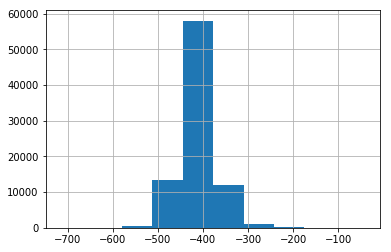

In [8]:
potential.potential_energy.hist()

In [9]:
magnetic.head()

molecule_name  atom_index          XX            YX                 ZX  \
0  dsgdb9nsd_000001           0  195.375000  0.0000000000 -0.000100016593933   
1  dsgdb9nsd_000001           1   31.343750 -1.2314453125  4.054687500000000   
2  dsgdb9nsd_000001           2   31.578125  1.2177734375 -4.148437500000000   
3  dsgdb9nsd_000001           3   31.515625  4.1093750000  1.272460937500000   
4  dsgdb9nsd_000001           4   31.406250 -4.0937500000 -1.179687500000000   

             XY          YY                 ZY                 XZ  \
0  0.0000000000  195.375000  0.000699996948242 -0.000100016593933   
1 -1.2314453125   28.953125 -1.717773437500000  4.054687500000000   
2  1.2177734375   28.906250 -1.603515625000000 -4.148437500000000   
3  4.1093750000   33.906250  1.695312500000000  1.272460937500000   
4 -4.0937500000   34.062500  1.625976562500000 -1.179687500000000   

                  YZ          ZZ  
0  0.000699996948242  195.375000  
1 -1.717773437500000   34.093750  
2 -1.603515625000000   33.906250  
3  1.695312500000000   28.953125  
4  1.625976562500000   28.906250

In [10]:
# train['scalar_coupling_constant'].apply(int).value_counts()

In [11]:
y = train['scalar_coupling_constant']

In [13]:
train = reduce_mem_usage(pd.read_csv('train_0.csv', index_col=0))
test = reduce_mem_usage(pd.read_csv('test_0.csv', index_col=0))

Mem. usage decreased to 746.32 Mb (75.0% reduction)
Mem. usage decreased to 391.87 Mb (75.6% reduction)


In [14]:
train_1 = reduce_mem_usage(pd.read_csv('train_1.csv', index_col=0))
test_1 = reduce_mem_usage(pd.read_csv('test_1.csv', index_col=0))

Mem. usage decreased to 315.41 Mb (73.1% reduction)
Mem. usage decreased to 169.65 Mb (73.1% reduction)


In [15]:
fs0 = [f for f in train_1.columns if f not in train.columns]
fs0

['c_x',
 'c_y',
 'c_z',
 'x_closest_0',
 'y_closest_0',
 'z_closest_0',
 'x_closest_1',
 'y_closest_1',
 'z_closest_1',
 'distance',
 'distance_center0',
 'distance_center1',
 'distance_c0',
 'distance_c1',
 'distance_f0',
 'distance_f1',
 'cos_c0_c1',
 'cos_f0_f1',
 'cos_center0_center1',
 'cos_c0',
 'cos_c1',
 'cos_f0',
 'cos_f1',
 'cos_center0',
 'cos_center1',
 'atom_n']

In [17]:
train_3 = reduce_mem_usage(pd.read_csv('input/train_giba.csv', index_col=None))
test_3 = reduce_mem_usage(pd.read_csv('input/test_giba.csv', index_col=None))

Mem. usage decreased to 910.68 Mb (71.8% reduction)
Mem. usage decreased to 501.79 Mb (71.2% reduction)


In [18]:
fs1 = [f for f in train_3.columns if f not in (train.columns.tolist() + fs0)]
fs1

['molecule_name',
 'id',
 'scalar_coupling_constant',
 'ID',
 'structure_atom_0',
 'structure_x_0',
 'structure_y_0',
 'structure_z_0',
 'structure_atom_1',
 'structure_x_1',
 'structure_y_1',
 'structure_z_1',
 'typei',
 'N1',
 'N2',
 'link0',
 'link1',
 'linkN',
 'dist_xyz',
 'inv_dist0',
 'inv_dist1',
 'inv_distP',
 'R0',
 'R1',
 'E0',
 'E1',
 'inv_dist0R',
 'inv_dist1R',
 'inv_distPR',
 'inv_dist0E',
 'inv_dist1E',
 'inv_distPE',
 'linkM0',
 'linkM1',
 'min_molecule_atom_0_dist_xyz',
 'mean_molecule_atom_0_dist_xyz',
 'max_molecule_atom_0_dist_xyz',
 'sd_molecule_atom_0_dist_xyz',
 'min_molecule_atom_1_dist_xyz',
 'mean_molecule_atom_1_dist_xyz',
 'max_molecule_atom_1_dist_xyz',
 'sd_molecule_atom_1_dist_xyz',
 'molecule_name.1',
 'atom_index_1.1',
 'coulomb_C.x',
 'coulomb_F.x',
 'coulomb_H.x',
 'coulomb_N.x',
 'coulomb_O.x',
 'yukawa_C.x',
 'yukawa_F.x',
 'yukawa_H.x',
 'yukawa_N.x',
 'yukawa_O.x',
 'coulomb_C.y',
 'coulomb_F.y',
 'coulomb_H.y',
 'coulomb_N.y',
 'coulomb_O.y',
 '

In [19]:
train = pd.concat([train, train_1[fs0], train_3[fs1]], axis=1)
test = pd.concat([test, test_1[fs0], test_3[fs1]], axis=1)


In [20]:
train_type = pd.read_csv('input/train.csv.zip', usecols=['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])
test_type = pd.read_csv('input/test.csv.zip', usecols=['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])

train['type'] = train_type.type
test['type'] = test_type.type

train['molecule_name'] = train_type.molecule_name
test['molecule_name'] = test_type.molecule_name


In [21]:
train['atom_index_0'] = train_type.atom_index_0
test['atom_index_0'] = test_type.atom_index_0

train['atom_index_1'] = train_type.atom_index_1
test['atom_index_1'] = test_type.atom_index_1


In [22]:
train = pd.merge(train, scaler, how = 'left',
                  left_on  = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'],
                  right_on = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])

In [23]:
train_babel_feat = pd.read_csv('input/train_ob_charges.csv')
test_babel_feat = pd.read_csv('input/test_ob_charges.csv')


In [24]:
train_babel_feat.shape

(1533537, 15)

In [25]:
train_babel_feat['atom_index_0'] = train_babel_feat.atom_index
train_babel_feat['atom_index_1'] = train_babel_feat.atom_index

test_babel_feat['atom_index_0'] = test_babel_feat.atom_index
test_babel_feat['atom_index_1'] = test_babel_feat.atom_index


In [26]:
bfs =  ['molecule_name', 'atom_index_0'] + ['eem', 'qtpie']

In [27]:
train = train.merge(train_babel_feat[bfs], how = 'left', 
                 on=['molecule_name', 'atom_index_0'])

bfs =  ['molecule_name', 'atom_index_1'] + ['eem', 'qtpie']
train = train.merge(train_babel_feat[bfs], how = 'left', 
                 on=['molecule_name', 'atom_index_1'])

In [28]:

bfs =  ['molecule_name', 'atom_index_0'] + ['eem', 'qtpie']
test = test.merge(test_babel_feat[bfs], how = 'left', 
                 on=['molecule_name', 'atom_index_0'])


In [29]:
bfs =  ['molecule_name', 'atom_index_1'] + ['eem', 'qtpie']
test = test.merge(test_babel_feat[bfs], how = 'left', 
                 on=['molecule_name', 'atom_index_1'])

In [30]:
train.head()

atom_index_0  atom_index_1  type  atom_index_x  atom_0               x_0  \
0             1             0  1JHC             1       0  0.00214958190918   
1             1             2  2JHH             1       0  0.00214958190918   
2             1             3  2JHH             1       0  0.00214958190918   
3             1             4  2JHH             1       0  0.00214958190918   
4             2             0  1JHC             2       0  1.01171875000000   

                 y_0                z_0        EN_x           rad_x  ...  NF  \
0 -0.006031036376953  0.001976013183594  2.19921875  0.429931640625  ... NaN   
1 -0.006031036376953  0.001976013183594  2.19921875  0.429931640625  ... NaN   
2 -0.006031036376953  0.001976013183594  2.19921875  0.429931640625  ... NaN   
3 -0.006031036376953  0.001976013183594  2.19921875  0.429931640625  ... NaN   
4  1.463867187500000  0.000276565551758  2.19921875  0.429931640625  ... NaN   

   NO        fc              sd           pso            dso  \
0 NaN  83.00000  0.254638671875  1.2587890625  0.27197265625   
1 NaN -11.03125  0.353027343750  2.8574218750 -3.43359375000   
2 NaN -11.03125  0.353027343750  2.8593750000 -3.43359375000   
3 NaN -11.03125  0.353027343750  2.8593750000 -3.43359375000   
4 NaN  83.00000  0.254638671875  1.2587890625  0.27197265625   

               eem_x            qtpie_x              eem_y            qtpie_y  
0  0.161131359327947  0.773439349698371 -0.644530825087479 -3.093806799641671  
1  0.161131359327947  0.773439349698371  0.161131811379221  0.773442481023162  
2  0.161131359327947  0.773439349698371  0.161133990721081  0.773463412039650  
3  0.161131359327947  0.773439349698371  0.161133663659230  0.773461556880489  
4  0.161131811379221  0.773442481023162 -0.644530825087479 -3.093806799641671  

[5 rows x 205 columns]

In [31]:
train['q_0'] = train['eem_x'] * train['eem_y'] / train['dist'] ** 2
test['q_0'] = test['eem_x'] * test['eem_y'] / test['dist'] ** 2

train['q_1'] = train['qtpie_x'] * train['qtpie_y'] / train['dist'] ** 2
test['q_1'] = test['qtpie_x'] * test['qtpie_y'] / test['dist'] ** 2

In [32]:
scaler.columns

Index(['molecule_name', 'atom_index_0', 'atom_index_1', 'type', 'fc', 'sd',
       'pso', 'dso'],
      dtype='object')

In [33]:
train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

In [34]:
train['dist_0'] = np.linalg.norm(train_p_0 + train_p_1, axis=1)
test['dist_0'] = np.linalg.norm(test_p_0 + test_p_1, axis=1)

train['dist_1'] = np.max(train_p_0 * train_p_1, axis=1)
test['dist_1'] = np.max(test_p_0 * test_p_1, axis=1)

train['dist_2'] = np.min(train_p_0 * train_p_1, axis=1)
test['dist_2'] = np.min(test_p_0 * test_p_1, axis=1)

train['dist_3'] = np.var(train_p_0 * train_p_1, axis=1)
test['dist_3'] = np.var(test_p_0 * test_p_1, axis=1)

In [35]:
train['m_0'] = train.groupby(['molecule_name', 'atom_index_0'])['dist_2'].transform('max')
test['m_0'] = train.groupby(['molecule_name', 'atom_index_0'])['dist_2'].transform('max')

train['d_0'] = np.max(np.abs(train_p_0 - train_p_1), axis=1)
test['d_0'] = np.max(np.abs(test_p_0 - test_p_1), axis=1)


In [37]:
train_2 = reduce_mem_usage(pd.read_csv('input/train_2.csv', index_col=0))
test_2 = reduce_mem_usage(pd.read_csv('input/test_2.csv', index_col=0))

Mem. usage decreased to 524.20 Mb (78.0% reduction)
Mem. usage decreased to 281.96 Mb (78.0% reduction)


In [38]:
train_2.head()

id     molecule_name  atom_index_0  atom_index_1  type atom1 atom2  type0  \
0   0  dsgdb9nsd_000001             1             0  1JHC     H     C      0   
1   1  dsgdb9nsd_000001             1             2  2JHH     H     H      1   
2   2  dsgdb9nsd_000001             1             3  2JHH     H     H      1   
3   3  dsgdb9nsd_000001             1             4  2JHH     H     H      1   
4   4  dsgdb9nsd_000001             2             0  1JHC     H     C      0   

   type1  type2  ...  a1_nb_inring8  a1_nb_nb_h  a1_nb_nb_o  a1_nb_nb_c  \
0      0      0  ...              0           0           0           1   
1      0      0  ...              0           4           0           0   
2      0      0  ...              0           4           0           0   
3      0      0  ...              0           4           0           0   
4      0      0  ...              0           0           0           1   

   a1_nb_nb_n  a1_nb_nb_na        x_a1_nb    y_a1_nb            z_a1_nb  \
0           0            0 -0.52392578125  1.4375000  0.906250000000000   
1           0            0 -0.01269531250  1.0859375  0.008003234863281   
2           0            0 -0.01269531250  1.0859375  0.008003234863281   
3           0            0 -0.01269531250  1.0859375  0.008003234863281   
4           0            0 -0.52392578125  1.4375000  0.906250000000000   

   dist_to_type_mean  
0       0.9990234375  
1       1.0048828125  
2       1.0048828125  
3       1.0048828125  
4       0.9990234375  

[5 rows x 66 columns]

In [39]:
train_2.drop(labels=['atom_index_0', 'atom_index_1' ,'type' ,'atom1', 'atom2', 'id'], axis=1, inplace=True)
test_2.drop(labels=['atom_index_0', 'atom_index_1' ,'type' ,'atom1', 'atom2', 'id'], axis=1, inplace=True)

In [40]:
fs2 = [f for f in train_2.columns if f not in train.columns]
fs2

['type0',
 'type1',
 'type2',
 'type3',
 'x0',
 'y0',
 'z0',
 'x1',
 'y1',
 'z1',
 'a1_degree',
 'a1_hybridization',
 'a1_inring',
 'a1_inring3',
 'a1_inring4',
 'a1_inring5',
 'a1_inring6',
 'a1_inring7',
 'a1_inring8',
 'a1_nb_h',
 'a1_nb_o',
 'a1_nb_c',
 'a1_nb_n',
 'a1_nb_na',
 'a0_nb_degree',
 'a0_nb_hybridization',
 'a0_nb_inring',
 'a0_nb_inring3',
 'a0_nb_inring4',
 'a0_nb_inring5',
 'a0_nb_inring6',
 'a0_nb_inring7',
 'a0_nb_inring8',
 'a0_nb_nb_h',
 'a0_nb_nb_o',
 'a0_nb_nb_c',
 'a0_nb_nb_n',
 'a0_nb_nb_na',
 'x_a0_nb',
 'y_a0_nb',
 'z_a0_nb',
 'a1_nb_degree',
 'a1_nb_hybridization',
 'a1_nb_inring',
 'a1_nb_inring3',
 'a1_nb_inring4',
 'a1_nb_inring5',
 'a1_nb_inring6',
 'a1_nb_inring7',
 'a1_nb_inring8',
 'a1_nb_nb_h',
 'a1_nb_nb_o',
 'a1_nb_nb_c',
 'a1_nb_nb_n',
 'a1_nb_nb_na',
 'x_a1_nb',
 'y_a1_nb',
 'z_a1_nb',
 'dist_to_type_mean']

In [41]:
train = pd.concat([train, train_2[fs2]], axis=1)
test = pd.concat([test, test_2[fs2]], axis=1)


In [42]:
np.unique(train['type'])

array(['1JHC', '1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH', '3JHN'],
      dtype=object)

In [43]:
del train_1, train_2
del test_1, test_2

gc.collect()

237

In [44]:
def metric(df, preds):
    df["prediction"] = preds
    maes = []
    for t in df.type.unique():
        y_true = df[df.type==t].scalar_coupling_constant.values
        y_pred = df[df.type==t].prediction.values
        mae = np.log(metrics.mean_absolute_error(y_true, y_pred))
        maes.append(mae)
    return np.mean(maes)
#df for evaluate
eval_df = pd.DataFrame({"type": train["type"]})
eval_df["scalar_coupling_constant"] = y

In [45]:
train.head()

atom_index_0  atom_index_1  type  atom_index_x  atom_0               x_0  \
0             1             0  1JHC             1       0  0.00214958190918   
1             1             2  2JHH             1       0  0.00214958190918   
2             1             3  2JHH             1       0  0.00214958190918   
3             1             4  2JHH             1       0  0.00214958190918   
4             2             0  1JHC             2       0  1.01171875000000   

                 y_0                z_0        EN_x           rad_x  ...  \
0 -0.006031036376953  0.001976013183594  2.19921875  0.429931640625  ...   
1 -0.006031036376953  0.001976013183594  2.19921875  0.429931640625  ...   
2 -0.006031036376953  0.001976013183594  2.19921875  0.429931640625  ...   
3 -0.006031036376953  0.001976013183594  2.19921875  0.429931640625  ...   
4  1.463867187500000  0.000276565551758  2.19921875  0.429931640625  ...   

   a1_nb_inring8  a1_nb_nb_h  a1_nb_nb_o  a1_nb_nb_c  a1_nb_nb_n  a1_nb_nb_na  \
0              0           0           0           1           0            0   
1              0           4           0           0           0            0   
2              0           4           0           0           0            0   
3              0           4           0           0           0            0   
4              0           0           0           1           0            0   

         x_a1_nb    y_a1_nb            z_a1_nb  dist_to_type_mean  
0 -0.52392578125  1.4375000  0.906250000000000       0.9990234375  
1 -0.01269531250  1.0859375  0.008003234863281       1.0048828125  
2 -0.01269531250  1.0859375  0.008003234863281       1.0048828125  
3 -0.01269531250  1.0859375  0.008003234863281       1.0048828125  
4 -0.52392578125  1.4375000  0.906250000000000       0.9990234375  

[5 rows x 272 columns]

In [46]:
train.shape

(4658147, 272)

In [48]:
for f in ['structure_atom_0', 'structure_atom_1', 'molecule_name.1']:
    train[f] = train[f].astype('category')
    test[f] = test[f].astype('category')

In [42]:
from catboost import Pool, CatBoostClassifier, CatBoostRegressor



In [50]:
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
n_split = 5
kf = KFold(n_splits=n_split, random_state=666, shuffle=True)
    
for type_ in np.unique(train['type']):

    if type_ == '1JHC':
        a, b, c = 2 ** 9, -1, 0.03
    else:
        a, b, c = 2 ** 7, 15, 0.03
    
    params = {'num_leaves': a,
          'min_child_samples': 79,
          'objective': 'regression_l2',
          'max_depth': b,
          'learning_rate': c,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 666,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 3,
          'colsample_bytree': 0.9
         }
    
    train_ = train[train['type'] == type_]
    test_ = test[test['type'] == type_]
    
    train_index = train_.index
    test_index = test_.index
    
    y_ = y[train['type'] == type_]
    
    all_pos = np.sum(y_.apply(int).value_counts().index.values > 0)
    
#     if all_pos:
#         y_ = np.log1p(y_)
    
    all_pos = False
    
    
    features = [c for c in train_.columns if c not in ['id', 'molecule_name', 'x_0', 'y_0', 'z_0',
                                                       'x_1', 'y_1', 'z_1', 'atom_index',
                                                       'type', 'scalar_coupling_constant',
                                                       'atom_0', 'atom_1', 'fc', 'sd', 'pso', 'dso']]
    for i, (train_idx, valid_idx) in enumerate(kf.split(train_)):  
        print(f'Fold {i + 1}')
        x_train = train_[features]
        y_train = y_
        trn_data = lgb.Dataset(x_train.iloc[train_idx], label=y_train.iloc[train_idx])
        val_data = lgb.Dataset(x_train.iloc[valid_idx], label=y_train.iloc[valid_idx])

        num_round = 5000
        clf = lgb.train(params, trn_data, num_round, valid_sets=[trn_data, val_data],
                        verbose_eval=500, early_stopping_rounds=50)
        if all_pos:
            oof[train_index[valid_idx]] = np.expm1(clf.predict(x_train.iloc[valid_idx], 
                                                               num_iteration=clf.best_iteration))

            predictions[test_index] += np.expm1(clf.predict(test_[features],
                                                            num_iteration=clf.best_iteration)) / n_split

        else:
            oof[train_index[valid_idx]] = clf.predict(x_train.iloc[valid_idx], num_iteration=clf.best_iteration)

            predictions[test_index] += clf.predict(test_[features], num_iteration=clf.best_iteration) / n_split

    
print("CV score: {:<8.5f}".format(metric(eval_df, oof)))

Fold 1
Training until validation scores don't improve for 50 rounds.
[500]	training's l1: 0.743061	valid_1's l1: 0.900039
[1000]	training's l1: 0.554294	valid_1's l1: 0.790313
[1500]	training's l1: 0.452153	valid_1's l1: 0.745388
[2000]	training's l1: 0.381721	valid_1's l1: 0.719437
[2500]	training's l1: 0.328349	valid_1's l1: 0.702094
[3000]	training's l1: 0.28553	valid_1's l1: 0.689776
[3500]	training's l1: 0.250678	valid_1's l1: 0.680899
[4000]	training's l1: 0.221456	valid_1's l1: 0.673933
[4500]	training's l1: 0.196591	valid_1's l1: 0.668407
[5000]	training's l1: 0.175296	valid_1's l1: 0.664031
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.175296	valid_1's l1: 0.664031
Fold 2
Training until validation scores don't improve for 50 rounds.
[500]	training's l1: 0.744394	valid_1's l1: 0.89891
[1000]	training's l1: 0.555937	valid_1's l1: 0.790158
[1500]	training's l1: 0.454007	valid_1's l1: 0.745227
[2000]	training's l1: 0.38308	valid_1's l1: 0.718762
[2500]	tr

[3500]	training's l1: 0.408076	valid_1's l1: 0.453375
[4000]	training's l1: 0.402007	valid_1's l1: 0.449547
[4500]	training's l1: 0.39639	valid_1's l1: 0.44609
[5000]	training's l1: 0.390303	valid_1's l1: 0.442159
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.390303	valid_1's l1: 0.442159
Fold 3
Training until validation scores don't improve for 50 rounds.
[500]	training's l1: 0.515129	valid_1's l1: 0.531832
[1000]	training's l1: 0.474842	valid_1's l1: 0.500287
[1500]	training's l1: 0.453135	valid_1's l1: 0.483987
[2000]	training's l1: 0.439889	valid_1's l1: 0.474662
[2500]	training's l1: 0.427804	valid_1's l1: 0.466015
[3000]	training's l1: 0.417685	valid_1's l1: 0.458735
[3500]	training's l1: 0.409979	valid_1's l1: 0.453513
[4000]	training's l1: 0.403994	valid_1's l1: 0.449809
Early stopping, best iteration is:
[4047]	training's l1: 0.403386	valid_1's l1: 0.449415
Fold 4
Training until validation scores don't improve for 50 rounds.
[500]	training's l1: 0.515

[1500]	training's l1: 0.100329	valid_1's l1: 0.188905
[2000]	training's l1: 0.0818599	valid_1's l1: 0.182414
[2500]	training's l1: 0.0682037	valid_1's l1: 0.178235
[3000]	training's l1: 0.0577319	valid_1's l1: 0.175322
[3500]	training's l1: 0.0493321	valid_1's l1: 0.173291
[4000]	training's l1: 0.0424113	valid_1's l1: 0.17169
[4500]	training's l1: 0.036699	valid_1's l1: 0.170471
[5000]	training's l1: 0.0319223	valid_1's l1: 0.169565
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.0319223	valid_1's l1: 0.169565
Fold 5
Training until validation scores don't improve for 50 rounds.
[500]	training's l1: 0.176155	valid_1's l1: 0.2196
[1000]	training's l1: 0.126843	valid_1's l1: 0.193679
[1500]	training's l1: 0.0998586	valid_1's l1: 0.18281
[2000]	training's l1: 0.0813457	valid_1's l1: 0.176479
[2500]	training's l1: 0.0677151	valid_1's l1: 0.172541
[3000]	training's l1: 0.057258	valid_1's l1: 0.169781
[3500]	training's l1: 0.0488183	valid_1's l1: 0.167828
[4000]	traini

Fold 1
Training until validation scores don't improve for 50 rounds.
[500]	training's l1: 0.135548	valid_1's l1: 0.161261
[1000]	training's l1: 0.102076	valid_1's l1: 0.142241
[1500]	training's l1: 0.0828954	valid_1's l1: 0.13336
[2000]	training's l1: 0.0694208	valid_1's l1: 0.128053
[2500]	training's l1: 0.0591972	valid_1's l1: 0.124408
[3000]	training's l1: 0.0510949	valid_1's l1: 0.121861
[3500]	training's l1: 0.044558	valid_1's l1: 0.119986
[4000]	training's l1: 0.0391218	valid_1's l1: 0.118523
[4500]	training's l1: 0.0345765	valid_1's l1: 0.117346
[5000]	training's l1: 0.0307169	valid_1's l1: 0.116463
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.0307169	valid_1's l1: 0.116463
Fold 2
Training until validation scores don't improve for 50 rounds.
[500]	training's l1: 0.136289	valid_1's l1: 0.161887
[1000]	training's l1: 0.10264	valid_1's l1: 0.142305
[1500]	training's l1: 0.0833412	valid_1's l1: 0.133316
[2000]	training's l1: 0.069725	valid_1's l1: 0.127974

In [61]:
predictions

array([ 17.82673772, 189.04229443,  11.01097956, ...,   1.86107441,
         5.92050267, 119.0685028 ])

In [62]:
predictions

array([ 17.82673772, 189.04229443,  11.01097956, ...,   1.86107441,
         5.92050267, 119.0685028 ])

In [63]:
test.shape

(2505542, 268)

In [64]:
sub = pd.read_csv('input/sample_submission.csv.zip')

In [65]:
sub.head()

id  scalar_coupling_constant
0  4658147                         0
1  4658148                         0
2  4658149                         0
3  4658150                         0
4  4658151                         0

In [66]:
sub.shape

(2505542, 2)

In [67]:
len(predictions)

2505542

In [68]:
sub['scalar_coupling_constant'] = predictions

sub.to_csv("submission-lgbm-v0.3.7.csv", index=False)

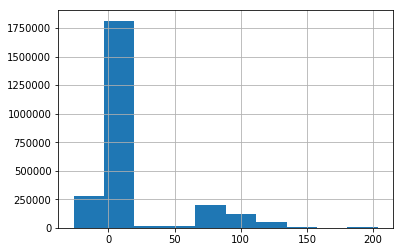

In [69]:
sub['scalar_coupling_constant'].hist()

In [70]:
pd.DataFrame(oof).to_csv('oofs/validation_lgbm_v0.3.7.csv', index=False)
pd.DataFrame(predictions).to_csv('oofs/test_lgbm_v0.3.7.csv', index=False)